In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import keras
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df = pd.read_csv('/content/BNB-USD.csv') # 01/05/2022 - 01/05/2023
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-05-01,377.765656,391.076996,377.289948,390.281982,390.281982,1553846706
1,2022-05-02,390.261261,392.216705,382.774414,389.670654,389.670654,1388077917
2,2022-05-03,389.634155,391.754761,380.346222,383.475800,383.475800,1295877765
3,2022-05-04,383.483551,402.862701,383.428040,402.502655,402.502655,1714496792
4,2022-05-05,402.465210,412.400360,372.552765,378.773621,378.773621,2389487319


In [3]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
df = df.drop_duplicates()
df = df.dropna()

In [5]:
df.drop('Adj Close', axis=1, inplace=True)

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [7]:
# scaler = MinMaxScaler()
# df[df.columns] = scaler.fit_transform(df[df.columns])

In [8]:
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2
n_rows = len(df)
train_rows = int(n_rows * train_ratio)
test_rows = int(n_rows * test_ratio)

X = df[['Open', 'High', 'Low','Volume']]
y = df['Close']

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_ratio+val_ratio, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=val_ratio/(test_ratio+val_ratio), shuffle=False)

# X_train = X[:train_rows]
# X_test = X[train_rows:train_rows+test_rows]
# X_val = X[train_rows+test_rows:]

# y_train = y[:train_rows]
# y_test = y[train_rows:train_rows+test_rows]
# y_val = y[train_rows+test_rows:]


In [9]:
print("Số lượng dữ liệu trong tập train:", len(X_train))
print("Số lượng dữ liệu trong tập test:", len(X_test))
print("Số lượng dữ liệu trong tập validation:", len(X_val))

Số lượng dữ liệu trong tập train: 256
Số lượng dữ liệu trong tập test: 73
Số lượng dữ liệu trong tập validation: 37


LN Model

In [10]:
from sklearn import linear_model , metrics
import time
from sklearn.metrics import r2_score

In [11]:
model_ln = linear_model.LinearRegression()
model_ln.fit(X_train,y_train) # bước traning dữ liệu 
start = time.time()
print('Giá Close dự đoán: ' , model_ln.predict(X_test.head()))	
end = time.time()
print("Thời gian chạy mô hình: " , end - start)

Giá Close dự đoán:  [281.67751969 290.35686158 307.52251443 293.70927021 297.9917936 ]
Thời gian chạy mô hình:  0.004189252853393555


In [12]:
# 1. mse:tổng bình phương sai số trên tập mẫu (Giá trị MSE càng nhỏ, mô hình dự báo càng chính xác.)
mse_linear = metrics.mean_squared_error(y_test,model_ln.predict(X_test))

# 2. rmse: căn của tổng bình phương sai số trên tập mẫu,được sử dụng để đánh giá sai số trung bình giữa giá trị dự báo và giá trị thực tế
#(giá trị này càng nhỏ thì mô hình càng chính xác)
rmse_linear = np.sqrt(mse_linear)

# 3. mae : trị tuyệt đối trung bình(giá trị này càng nhỏ thì mô hình càng chính xác)
mae_linear = metrics.mean_absolute_error(y_test,model_ln.predict(X_test))

# 4.r2_score(): đánh giá xem mô hình có phù hợp và tốt hay không, trả về giá trị nằm trong khoảng từ 0 đến 1, 
# với giá trị 0 có nghĩa là không có mối quan hệ, với giá trị là 1 có nghĩa là mô hình phù hợp và tốt 100%.
r2_linear = r2_score(y_test , model_ln.predict(X_test))

print('MSE: ' , mse_linear)
print('RMSE: ' , rmse_linear)
print('MAE: ' , mae_linear)
print('R2_squared: ' , r2_linear)

MSE:  17.821600017828775
RMSE:  4.221563693446869
MAE:  3.2837566303736097
R2_squared:  0.9204351304187168


In [13]:
predicted_close = model_ln.predict(X_val)

mse = metrics.mean_squared_error(y_val, predicted_close)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_val, predicted_close)
r2 = r2_score(y_val, predicted_close)

# In ra kết quả đánh giá hiệu suất của mô hình trên tập dữ liệu validate
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R2-squared:', r2)

MSE: 11.024500150517294
RMSE: 3.3203162726639905
MAE: 2.7091304281483017
R2-squared: 0.8986020621003948


In [14]:
# Lấy ra dữ liệu của 30 ngày tiếp theo
next_30_days_data = X_val[['Open', 'High', 'Low', 'Volume']].tail(30)

In [15]:
# Dự đoán giá Close của 30 ngày tiếp theo
predicted_close_next_30_days = model_ln.predict(next_30_days_data)

In [16]:
# Tạo DataFrame mới chứa dữ liệu về ngày và giá trị Close dự đoán
from datetime import datetime, timedelta
start_date = datetime(2023, 5, 1)
end_date = datetime(2023, 5, 30)
dates = pd.date_range(start=start_date, end=end_date, freq='D')
predicted_data = pd.DataFrame({'Date': dates, 'Giá Close Dự Đoán trong 30 ngày tiếp theo': predicted_close_next_30_days})
predicted_data = predicted_data.set_index('Date')
predicted_data.head()

,Giá Close Dự Đoán trong 30 ngày tiếp theo
Date,
2023-05-01,311.645102
2023-05-02,301.217708
2023-05-03,310.407065
2023-05-04,313.488642
2023-05-05,311.024188


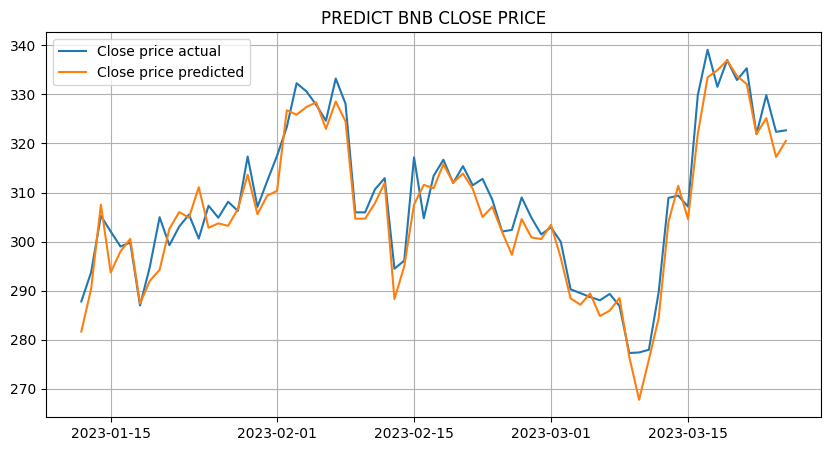

In [17]:
y_pred = model_ln.predict(X_test)
plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(X_test.index,y_test.values, label='Close price actual')
plt.plot(X_test.index,y_pred, label='Close price predicted')
plt.title("PREDICT BNB CLOSE PRICE")
plt.legend()
plt.show()

In [18]:
y_predict_1 = model_ln.predict(X_test.head())
for i in range(len(y_predict_1)):
  y_predict_1[i] = round(y_predict_1[i],0)

moi = pd.DataFrame({'Close thực tế' : y_test.head(),
                    'Close dự đoán' : y_predict_1,
                    'Độ lệch': y_predict_1 - y_test.head()})
moi.head()

,Close thực tế,Close dự đoán,Độ lệch
Date,,,
2023-01-12,287.812347,282.0,-5.812347
2023-01-13,293.733002,290.0,-3.733002
2023-01-14,305.241119,308.0,2.758881
2023-01-15,302.070648,294.0,-8.070648
2023-01-16,298.999237,298.0,-0.999237


ARIMA Model

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
n = len(df)
train_data = df.iloc[0:int(n*0.7)]
test_data = df.iloc[int(n*0.7):]

In [21]:
result = adfuller(train_data['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Nếu p-value > 0.05, ta không thể bác bỏ giả thuyết không có tính dừng
# Ta sẽ sử dụng phương pháp sai phân để biến đổi chuỗi thời gian
if result[1] > 0.05:
    diff_train_data = train_data['Close'].diff().dropna()
else:
    diff_train_data = train_data['Close']

# Kiểm tra lại tính dừng của chuỗi thời gian
result = adfuller(diff_train_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.629313
p-value: 0.005225
ADF Statistic: -3.629313
p-value: 0.005225


In [22]:
order = auto_arima(train_data['Close'], test="adf", seasonal=False, trace=True, stepwise=False)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3617.790, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3005.739, Time=0.97 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2828.485, Time=0.71 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.89 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1965.631, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1961.276, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1962.718, Time=0.20 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1964.910, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1964.695, Time=0.44 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1962.885, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1964.660, Time=0.54 sec
 ARIMA(3,0,0)(0,0,0)[0]            

In [23]:
model = ARIMA(train_data["Close"], order=order.order)
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [24]:
diff_test_data = test_data['Close'].diff().dropna()
pred_test_data = model_fit.forecast(len(diff_test_data))
mse_test = mean_squared_error(diff_test_data, pred_test_data)
print('MSE on test set:', mse_test)

MSE on test set: 83008.76144326979


In [25]:
n = len(df)
train_data = df.iloc[0:int(n*0.7)]
test_data = df.iloc[int(n*0.7):]

In [26]:
# Huấn luyện lại mô hình trên toàn bộ tập train và test
train_data_full = pd.concat([train_data, test_data], axis=0)
diff_train_data_full = train_data_full['Close'].diff().dropna()
model_full = ARIMA(diff_train_data_full, order=model.order)
model_full_fit = model_full.fit()

# Dự đoán trên toàn bộ dữ liệu
diff_data_full = df['Close'].diff().dropna()
pred_data_full = model_full_fit.forecast(len(diff_data_full))

# Tính toán lại giá trị thực tế
pred_data_full = pd.Series(pred_data_full, index=diff_data_full.index)
pred_data_full = pred_data_full.add(df['Close'].shift(), fill_value=df['Close'].iloc[0])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


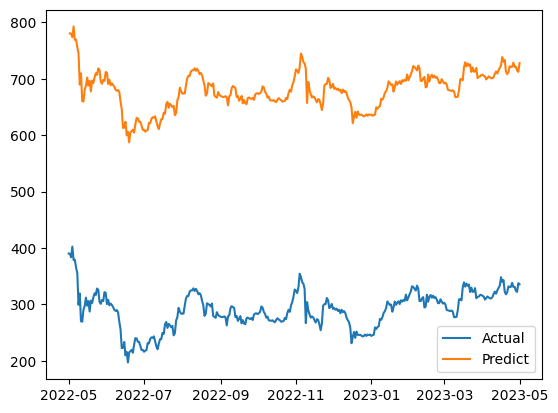

In [27]:
plt.plot(df['Close'], label='Actual')
plt.plot(pred_data_full, label='Predict')
plt.legend()
plt.show()

Recurrent Neural Networks (RNN)

In [28]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [29]:
data = df[['Open', 'High', 'Low', 'Close', 'Volume']].values

In [30]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [31]:
train_size = int(len(scaled_data) * train_ratio)
val_size = int(len(scaled_data) * val_ratio)

In [32]:
train_data = scaled_data[:train_size, :]
val_data = scaled_data[train_size:train_size+val_size, :]
test_data = scaled_data[train_size+val_size:, :]

In [33]:
#Hàm này được sử dụng để tạo dữ liệu cho mô hình 
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back), :])
        Y.append(data[i+look_back, 3])
    return np.array(X), np.array(Y)

In [34]:
#Look_back: số lượng các điểm dữ liệu trước đó (tức là quá khứ) được sử dụng để dự đoán điểm dữ liệu hiện tại
look_back = 30

In [35]:
train_X, train_Y = create_dataset(train_data, look_back)
val_X, val_Y = create_dataset(val_data, look_back)
test_X, test_Y = create_dataset(test_data, look_back)

In [36]:
#Khởi tạo một mô hình Recurrent Neural Networks (RNN) sử dụng framework TensorFlow
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(look_back, 5)),
    tf.keras.layers.Dense(1)
])

In [37]:
#biên dịch mô hình RNN
model.compile(loss='mean_squared_error', optimizer='adam')

In [38]:
#huấn luyện mô hình RNN
model.fit(train_X, train_Y, epochs=10, batch_size=64, validation_data=(val_X, val_Y))


Epoch 1/10
4/4 [==============================] - 3s 230ms/step - loss: 0.1335 - val_loss: 0.0705
Epoch 2/10
4/4 [==============================] - 0s 28ms/step - loss: 0.0281 - val_loss: 0.0032
Epoch 3/10
4/4 [==============================] - 0s 29ms/step - loss: 0.0177 - val_loss: 0.0250
Epoch 4/10
4/4 [==============================] - 0s 28ms/step - loss: 0.0225 - val_loss: 0.0088
Epoch 5/10
4/4 [==============================] - 0s 26ms/step - loss: 0.0117 - val_loss: 0.0018
Epoch 6/10
4/4 [==============================] - 0s 31ms/step - loss: 0.0095 - val_loss: 0.0056
Epoch 7/10
4/4 [==============================] - 0s 30ms/step - loss: 0.0109 - val_loss: 0.0066
Epoch 8/10
4/4 [==============================] - 0s 26ms/step - loss: 0.0104 - val_loss: 0.0037
Epoch 9/10
4/4 [==============================] - 0s 26ms/step - loss: 0.0087 - val_loss: 0.0019
Epoch 10/10
4/4 [==============================] - 0s 31ms/step - loss: 0.0083 - val_loss: 0.0024


In [39]:
test_predict = model.predict(test_X)
test_predict = scaler.inverse_transform(np.concatenate((test_X[:, -1, :4], test_predict), axis=1))[:, -1]
test_Y = scaler.inverse_transform(np.concatenate((test_X[:, -1, :4], test_Y.reshape(-1, 1)), axis=1))[:, -1]
test_score = mean_squared_error(test_Y, test_predict)
print('Test MSE: %.2f' % (test_score))

2/2 [==============================] - 1s 11ms/step
Test MSE: 118851575887180240.00


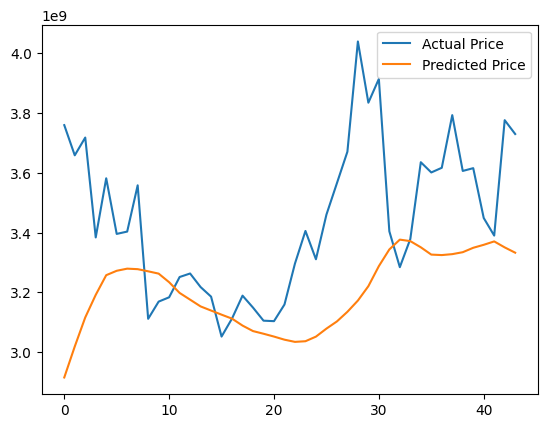

In [40]:
plt.plot(test_Y, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.legend()
plt.show()

**GRU** Model

In [41]:
!pip install tensorflow numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
model_gru = Sequential()
model_gru.add(GRU(128, input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(Dense(1))
model_gru.compile(loss='mse', optimizer='adam')

In [43]:
history_gru = model_gru.fit(train_X, train_Y, epochs=10, batch_size=64, validation_data=(val_X, val_Y), verbose=2, shuffle=False)

Epoch 1/10
4/4 - 4s - loss: 0.1373 - val_loss: 0.0261 - 4s/epoch - 1s/step
Epoch 2/10
4/4 - 0s - loss: 0.0109 - val_loss: 0.0336 - 331ms/epoch - 83ms/step
Epoch 3/10
4/4 - 0s - loss: 0.0326 - val_loss: 0.0163 - 374ms/epoch - 94ms/step
Epoch 4/10
4/4 - 0s - loss: 0.0124 - val_loss: 0.0035 - 365ms/epoch - 91ms/step
Epoch 5/10
4/4 - 0s - loss: 0.0081 - val_loss: 0.0174 - 386ms/epoch - 97ms/step
Epoch 6/10
4/4 - 0s - loss: 0.0121 - val_loss: 0.0161 - 341ms/epoch - 85ms/step
Epoch 7/10
4/4 - 1s - loss: 0.0089 - val_loss: 0.0060 - 600ms/epoch - 150ms/step
Epoch 8/10
4/4 - 1s - loss: 0.0053 - val_loss: 0.0022 - 585ms/epoch - 146ms/step
Epoch 9/10
4/4 - 0s - loss: 0.0056 - val_loss: 0.0025 - 452ms/epoch - 113ms/step
Epoch 10/10
4/4 - 0s - loss: 0.0059 - val_loss: 0.0022 - 354ms/epoch - 89ms/step


In [44]:
test_predict_gru = model_gru.predict(test_X)

2/2 [==============================] - 1s 39ms/step


In [45]:
mse_gru = mean_squared_error(test_Y, test_predict_gru)
print('Mean Squared Error của mô hình GRU trên dữ liệu kiểm tra là', mse_gru)

Mean Squared Error của mô hình GRU trên dữ liệu kiểm tra là 1.191665501002719e+19


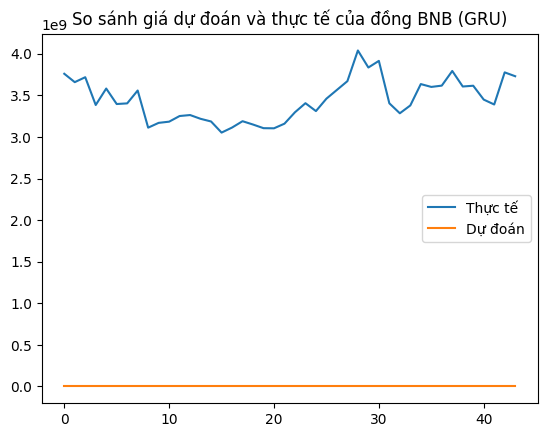

In [46]:
# Vẽ biểu đồ giá thực tế
plt.plot(test_Y, label='Thực tế')

# Vẽ biểu đồ giá dự đoán
plt.plot(test_predict_gru, label='Dự đoán')

# Đặt tiêu đề và chú thích cho biểu đồ
plt.title('So sánh giá dự đoán và thực tế của đồng BNB (GRU)')
plt.legend()

# Hiển thị biểu đồ
plt.show()

Exponential Smoothing (ETS)

In [47]:
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from itertools import product

In [48]:
#Tạo model Exponential Smoothing (Triple exponential smoothing (Holt Winters))
model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods = 30)
print(model_fit.params)
#Train model với data y_train
model_fit = model.fit()
#Dự đoán tập giá trị BNB
y_pred_test = model_fit.forecast(len(y_test))
y_pred_validate = model_fit.predict(start=X_val.index[0], end=X_val.index[-1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


const     289.120593
ar.L1       0.958156
ma.L1      -0.116891
ma.L2       0.184811
sigma2    115.510354
dtype: float64


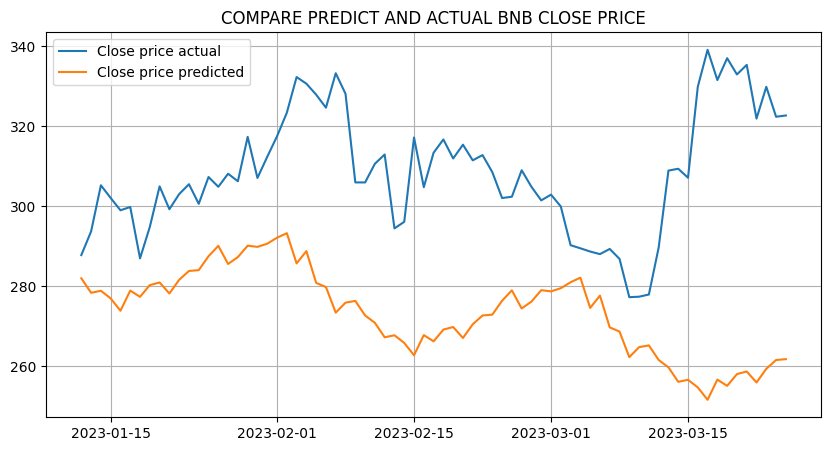

In [49]:
plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(X_test.index,y_test.values, label='Close price actual')
plt.plot(X_test.index,y_pred_test, label='Close price predicted')
plt.title("COMPARE PREDICT AND ACTUAL BNB CLOSE PRICE")
plt.legend()
plt.show()

In [50]:
# Đánh gia mo hinh trên tap test
print('R-squared:', r2_score(y_test.values, y_pred_test)) 
print('MSE:', metrics.mean_squared_error(y_test.values, y_pred_test)) 
print('RMSE:', metrics.mean_squared_error(y_test.values, y_pred_test, squared=False)) 
print('MAPE:', metrics.mean_absolute_percentage_error(y_test.values, y_pred_test) * 100) 
print('MAE:', metrics.mean_absolute_error(y_test.values, y_pred_test)) 

R-squared: -6.190566347585105
MSE: 1610.602744938917
RMSE: 40.13231546944329
MAPE: 11.057175374427324
MAE: 34.82772820933223
